## Setup

In [1]:
# standard library imports
import os

# related third party imports
import numpy as np
import tensorflow as tf
from tensorflow import keras

# local application/library specific imports
from uncertainty_rejection.analysis import (
    load_predictions,
    compute_uncertainty,
    compute_confidence,
    concat_get_idx,
    compute_metrics_rej
)

from uncertainty_rejection.plotting import (
    hist_unc_plot1,
    hist_unc_plot3, 
    count_unc_plot1,
    rejection_mixmetric_plot3,
    rejection_setmetric_plot1,
    rejection_setmetric_plot3,
)

2022-11-24 13:17:06.644862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 13:17:06.733615: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def load_mnist_data():
    """Load MNIST data."""
    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

    # scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255
    # reshape images to (28, 28, 1)
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    print(f"x shape: {x_train.shape} \t(both train & test)")
    print(f"y shape: {y_train.shape} \t\t(both train & test)")
    print(f"# train samples: {x_train.shape[0]}")
    print(f"# test samples:  {x_test.shape[0]}")

    return x_train, y_train, x_test, y_test

In [3]:
def load_notmnist_data():
    """Load Not-MNIST data."""
    # features X
    x_test = np.load("./not_mnist_images.npy")
    x_test = np.expand_dims(x_test, -1)
    # labels y
    y_test = np.load("./not_mnist_labels.npy")
    y_test = y_test.squeeze()
    print(f"x shape: {x_test.shape} \t(only test)")
    print(f"y shape: {y_test.shape} \t\t(only test)")
    print(f"# test samples: {x_test.shape[0]}")
    return x_test, y_test

## Load data


In [4]:
# load MNIST data (do not need train data or test features)
_, _, _, y_mnist = load_mnist_data()

x shape: (60000, 28, 28, 1) 	(both train & test)
y shape: (60000,) 		(both train & test)
# train samples: 60000
# test samples:  10000


In [5]:
# load Not-MNIST data (do not need features)
_, y_notmnist = load_notmnist_data()
# give not-MNIST observation a different label -> should be incorrect
y_notmnist.fill(999)

x shape: (18724, 28, 28, 1) 	(only test)
y shape: (18724,) 		(only test)
# test samples: 18724


Concatenate true labels and get index vectors. This is useful for the plotting functions later on.

In [6]:
y_true_all, idlist, idx_mnist, idx_notmnist, *_ = concat_get_idx(y_mnist, y_notmnist)

## Load predictions

In [7]:
# TODO: remove
# # shape should be (observations, samples, classes)
# y_stack_all = np.load('./predictions_all.npy')
# print(y_stack_all.shape)
# y_stack_all = np.transpose(y_stack_all, (0, 2, 1))
# print(y_stack_all.shape)
# np.save('./predictions_all.npy', y_stack_all)

In [8]:
# load predictions
y_stack_all, y_mean_all, y_label_all = load_predictions('./predictions_all.npy')
NUM_CLASSES = y_stack_all.shape[-1]

y_stack shape: 	(28724, 128, 10)
y_mean shape: 	(28724, 10)
y_label shape: 	(28724,)


## Compute uncertainty and confidence

The uncertainty/confidence in a prediction can be quantified in 2 ways:
- Total uncertainty, which is entropy-based.\
  => can be decomposed in aleatoric (i.e. data) and epistemic (i.e. model) uncertainty
- Confidence, which directly uses the predicted probabilities.\
  => cannot be decomposed

In [9]:
# uncertainty (TU, AU, EU)
unc_tot, unc_ale, unc_epi = compute_uncertainty(y_stack_all)
# confidence
conf = compute_confidence(y_stack_all)

## Histograms

### `hist_unc_plot1`

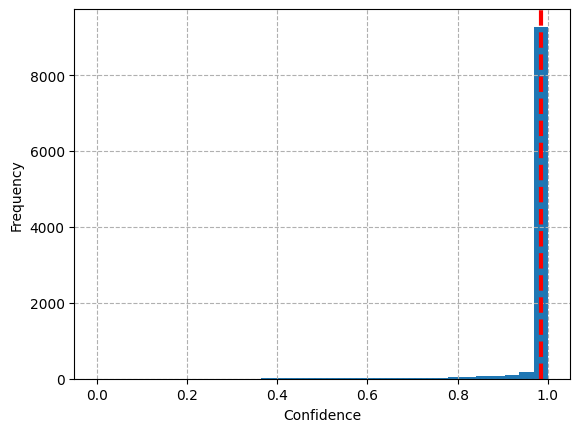

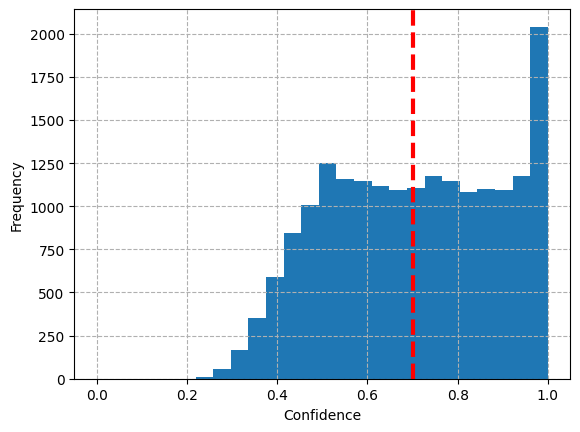

In [10]:
# confidence on mnist observations
hist_unc_plot1(conf, idx=idx_mnist, unc_type="Conf")

# confidence on notmnist observations
hist_unc_plot1(conf, idx=idx_notmnist, unc_type="Conf")

### `hist_unc_plot3`

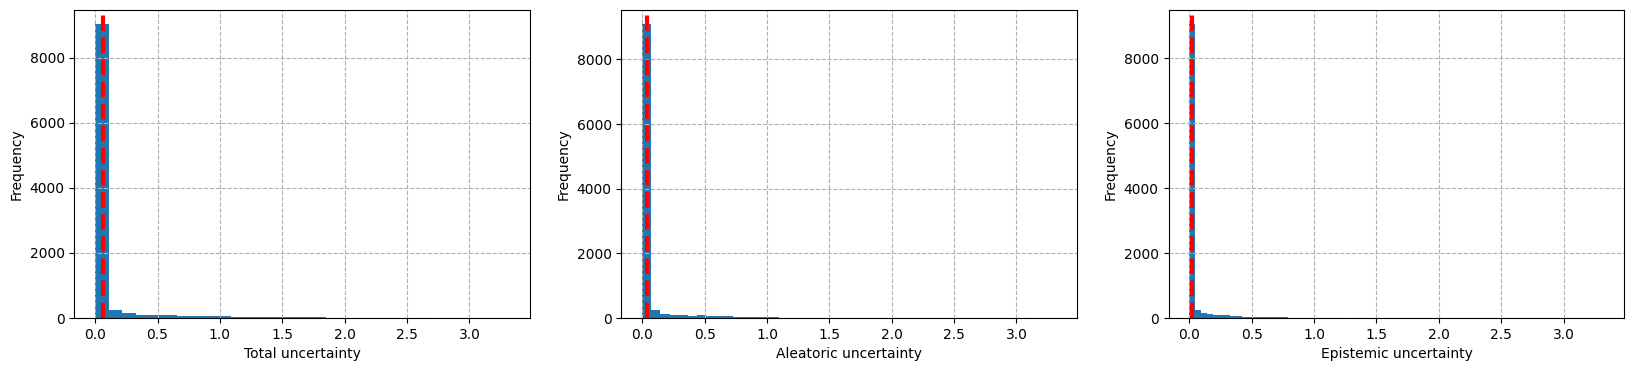

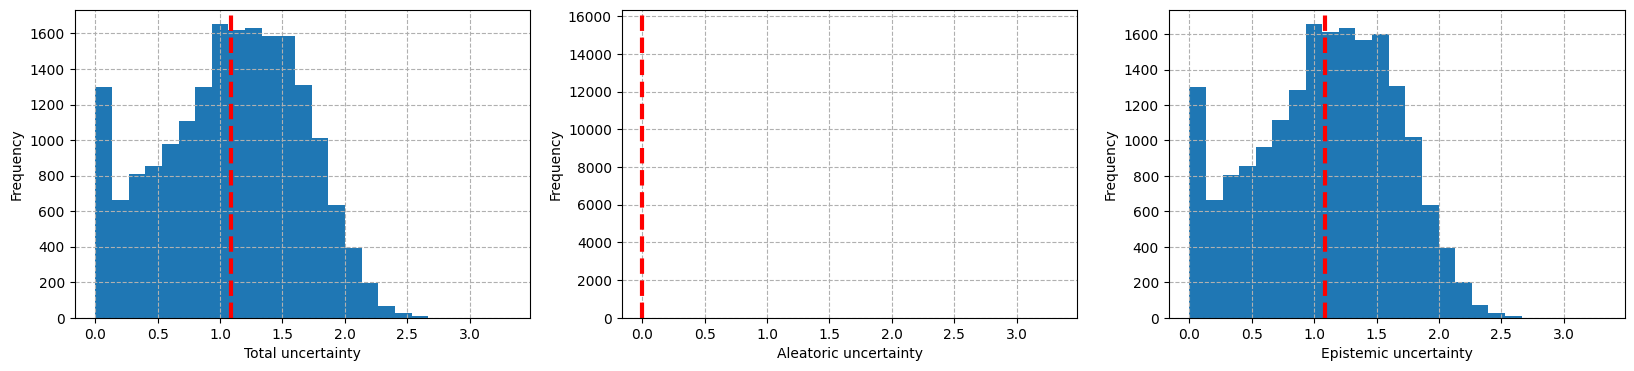

In [11]:
# uncertainty on mnist observations
hist_unc_plot3(unc_tot, unc_ale, unc_epi, idx=idx_mnist, num_classes=NUM_CLASSES)

# uncertainty on notmnist observations
hist_unc_plot3(unc_tot, unc_ale, unc_epi, idx=idx_notmnist, num_classes=NUM_CLASSES)

## Counts

### `count_unc_plot1`

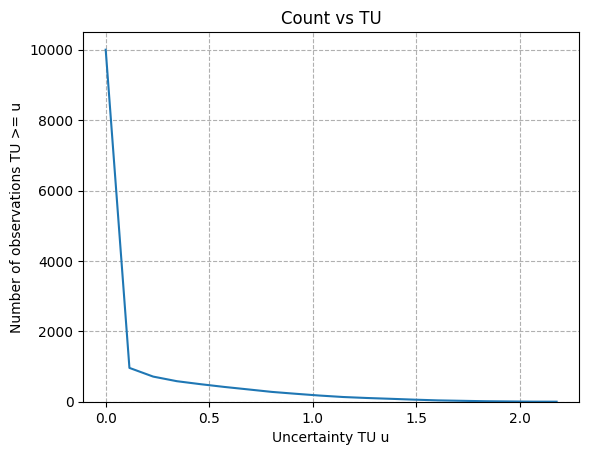

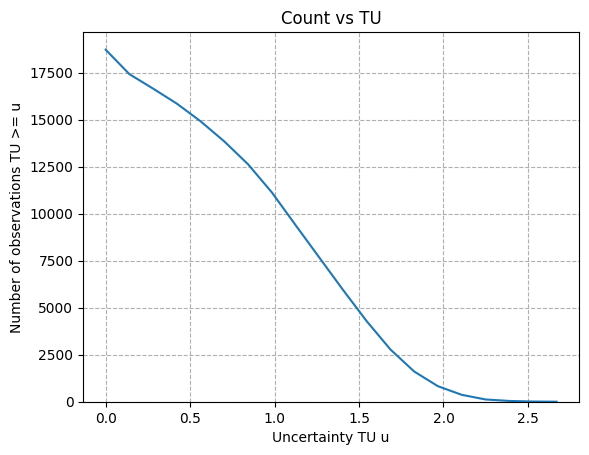

In [12]:
# count vs unc on mnist observations
count_unc_plot1(unc_tot, idx=idx_mnist, unc_type="TU")

# count vs unc on notmnist observations
count_unc_plot1(unc_tot, idx=idx_notmnist, unc_type="TU")

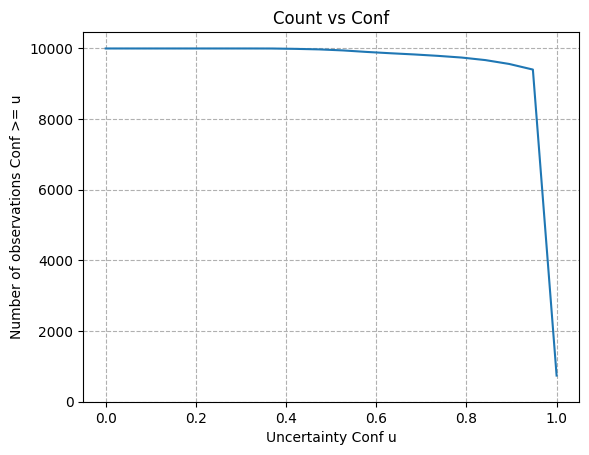

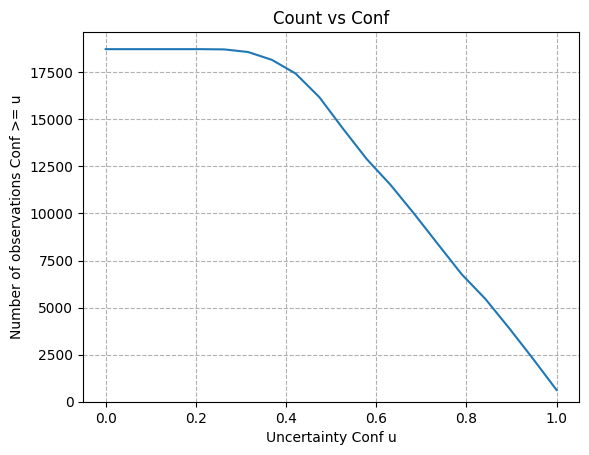

In [13]:
# count vs conf on mnist observations
count_unc_plot1(conf, idx=idx_mnist, unc_type="Conf")

# count vs conf on notmnist observations
count_unc_plot1(conf, idx=idx_notmnist, unc_type="Conf")

## Classification with rejection

Classification with rejection is a framework where the role of uncertainty is key. 
When the prediction's uncertainty is too high, the model abstains from predicting and the observation is passed on to a human expert who takes the final decision. 
It is useful for applications where making an error can be more costly than asking a human expert for help.

### `compute_metrics_rej`

`compute_metrics_rej` is the core function of the package. It takes as arguments the observations' true label, predicted label, uncertainty value and returns 3 evaluation metrics for a specific rejection treshold. The rejection treshold can either be relative (i.e. reject `threshold` percent) or absolute (i.e. reject if uncertainty is >= `threshold`). The 3 evaluation metrics are Non-rejected accuracy, Classification quality and Rejection quality, which follows the work of [Condessa et al. (2017)](https://doi.org/10.1016/j.patcog.2016.10.011).

In [14]:
threshold = 0.20 # reject x percent (relative)

# confusion matrix for all observations
compute_metrics_rej(threshold, y_true_all, y_label_all, unc_tot)

             Non-rejected    Rejected
---------  --------------  ----------
Correct              9796          26
Incorrect           13183        5719

  Non-rejected accuracy    Classification quality    Rejection quality
-----------------------  ------------------------  -------------------
                 0.4263                    0.5401             114.2981


(0.4263022759911223, 0.5401406489346887, 114.29807590568356)

In [15]:
threshold = 2.0 # reject if unc >= x

# confusion matrix for all observations
compute_metrics_rej(threshold, y_true_all, y_label_all, unc_tot, relative=False)

             Non-rejected    Rejected
---------  --------------  ----------
Correct              9819           3
Incorrect           18201         701

  Non-rejected accuracy    Classification quality    Rejection quality
-----------------------  ------------------------  -------------------
                 0.3504                    0.3662             121.4196


(0.35042826552462525, 0.3662442556746971, 121.41963813353084)

#### `rejection_setmetric_plot1`

It is more interesting to plot the metrics for a varying threshold. `rejection_setmetric_plot1` plots 1 metric (`metric` is one of {'nra', 'cq', 'rq'})  based on 1 uncertainty type (`unc_type` is one of {'TU', 'AU', 'EU', 'Conf'}). Again, threshold can be relative or absolute.

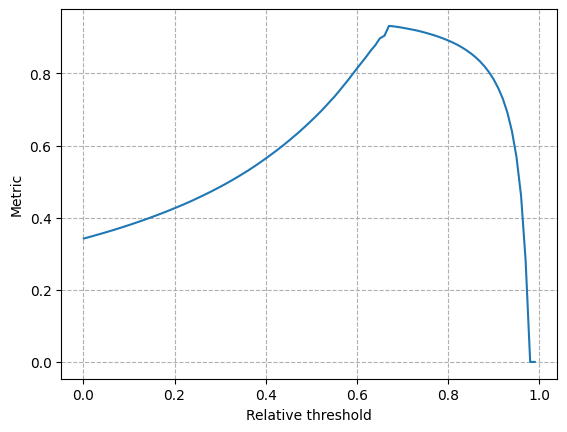

In [16]:
# relative rejecting based on unc for all observations
rejection_setmetric_plot1(y_true_all, y_stack_all, unc_tot, metric="nra", unc_type="TU")

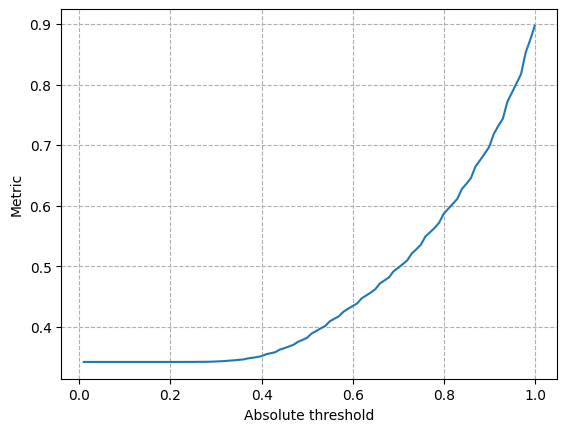

In [17]:
# absolute rejecting based on conf for all observations
rejection_setmetric_plot1(y_true_all, y_stack_all, conf, metric="nra", unc_type="Conf", relative=False)

#### `rejection_setmetric_plot3`

`rejection_setmetric_plot3` is very similar to `rejection_setmetric_plot1` but plots the metric for all 3 entropy-based uncertainties ('TU', 'AU', 'EU').

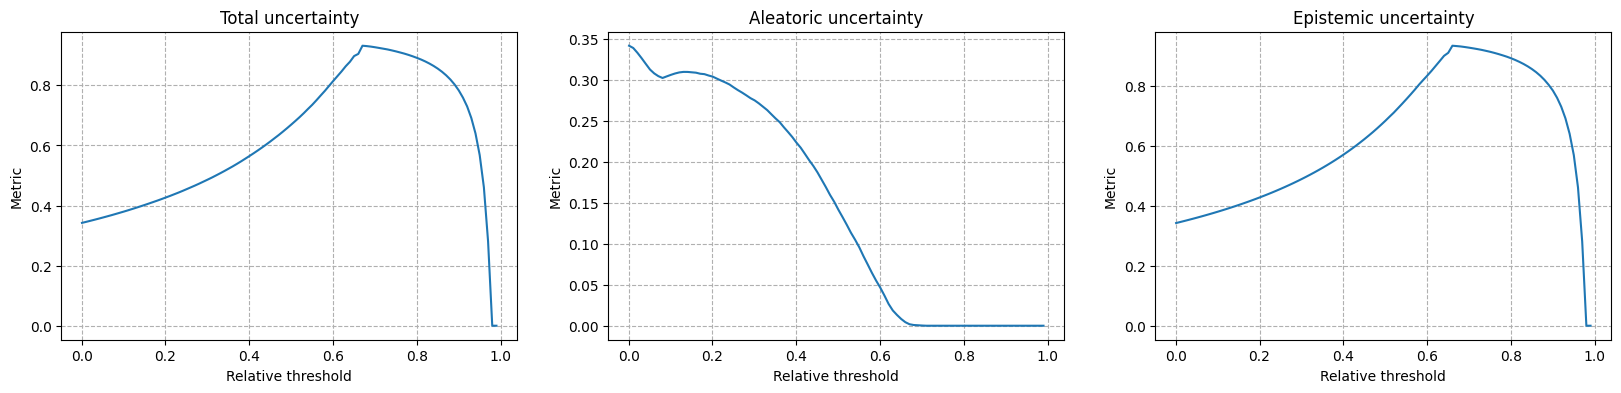

In [18]:
# relative rejecting based on unc for all observations
rejection_setmetric_plot3(y_true_all, y_stack_all, unc_tot, unc_ale, unc_epi, metric="nra", unc_type="TU")

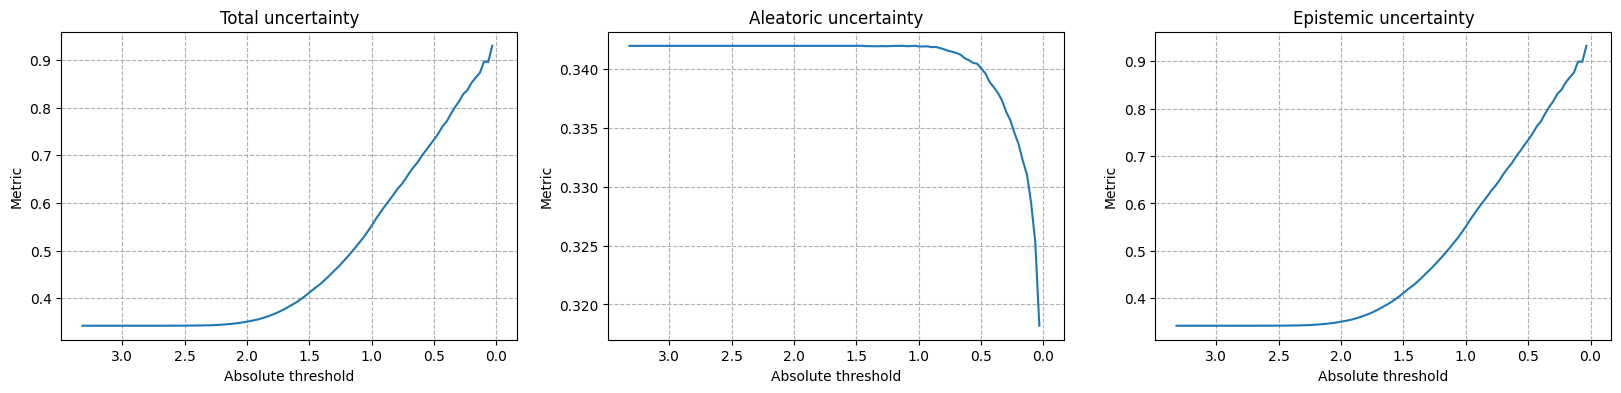

In [19]:
# absolute rejecting based on unc for all observations
rejection_setmetric_plot3(y_true_all, y_stack_all, unc_tot, unc_ale, unc_epi, metric="nra", unc_type="TU", relative=False)

#### `rejection_mixmetric_plot3`

`rejection_mixmetric_plot3` plots all 3 metrics ('nra', 'cq', 'rq') based on 1 uncertainty type.

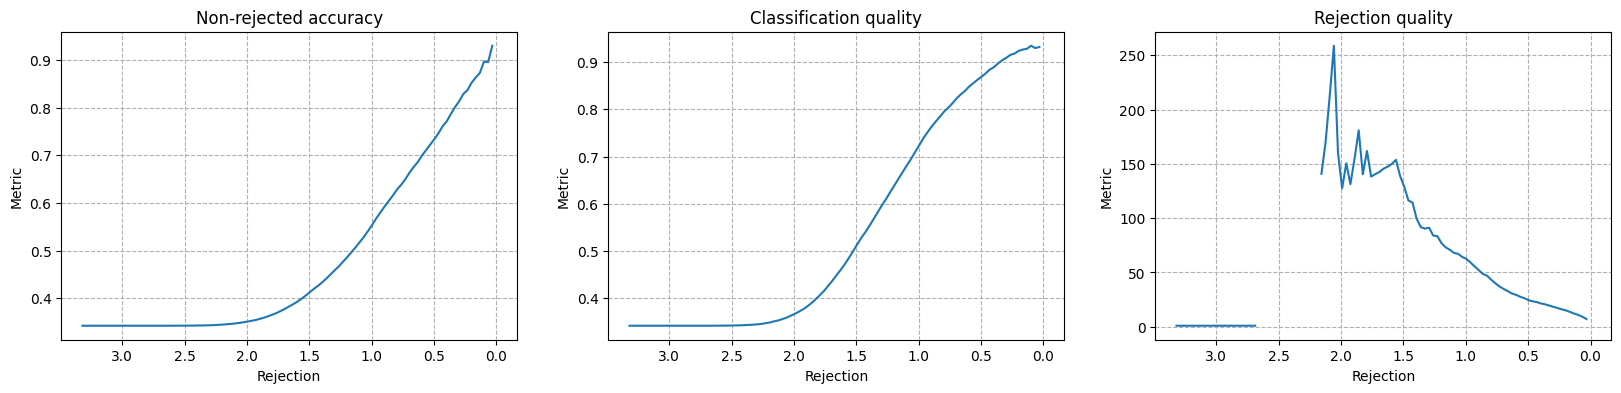

In [20]:
# confusion matrix for all observations
rejection_mixmetric_plot3(y_true_all, y_stack_all, unc_tot, unc_type="TU", relative=False)